In [75]:
import geopandas as gpd
import geopy.distance
import os
import numpy as np

In [2]:
# data_path = 'C:/Users/demo/Desktop/Lattitude/datas/'
data_path = 'datas'
os.makedirs(data_path, exist_ok=True)

In [3]:
# Load the data for French garge points
file_name = 'dataset_charge_points.feather'

bornes = gpd.read_feather(os.path.join(data_path, file_name))

# Load the data for the communes
file_name = 'dataset_communes.feather'

datas = gpd.read_feather(os.path.join(data_path, file_name))

file_name = 'TMJA2018'

tmja = gpd.read_feather(os.path.join(data_path,file_name + '.feather'))

--------

In [4]:
tmja_wrs84 = tmja.to_crs(4326)

In [5]:
tmja_wrs84.keys()

Index(['dateRefere', 'route', 'longueur', 'prD', 'depPrD', 'concession',
       'absD', 'cumulD', 'xD', 'yD', 'zD', 'prF', 'depPrF', 'concessi_1',
       'absF', 'cumulF', 'xF', 'yF', 'zF', 'cote', 'anneeMesur', 'typeCompta',
       'tmja', 'pctPL', 'geometry'],
      dtype='object')

In [6]:
geo_list = tmja_wrs84.geometry

In [7]:
points_list = []

In [8]:
lenght_geolist = len(geo_list)

for i in range(lenght_geolist):
    points_list.append(list(geo_list[0].coords))

tmja_wrs84['list_points'] = points_list

In [9]:
tmja_wrs84['Road_center'] = tmja_wrs84.to_crs('+proj=cea').geometry.centroid.to_crs(tmja_wrs84.crs)

---------

In [10]:
datas[['nb_vp', 'nb_vp_rechargeables_gaz', 'nb_vp_rechargeables_el']].describe()

,nb_vp,nb_vp_rechargeables_gaz,nb_vp_rechargeables_el
count,314535.000000,314535.000000,314535.000000
mean,1863.089103,0.119955,19.333298
std,7242.008462,2.711924,103.856129
min,1.000000,0.000000,0.000000
25%,236.000000,0.000000,1.000000
50%,522.000000,0.000000,3.000000
75%,1285.000000,0.000000,10.000000
max,405637.000000,371.000000,6156.000000


In [11]:
datas.keys()

Index(['insee', 'nom', 'wikipedia', 'surf_ha', 'geometry', 'PMUN', 'PCAP',
       'PTOT', 'nb_vp', 'libepci', 'libgeo', 'nb_vp_rechargeables_gaz',
       'date_arrete', 'epci', 'nb_vp_rechargeables_el', 'dep', 'dep_name',
       'region_name'],
      dtype='object')

In [12]:
communes_fin_2022 = datas.loc[datas['date_arrete']=='2022-12-31']

In [13]:
communes_fin_2022[['nb_vp', 'nb_vp_rechargeables_gaz', 'nb_vp_rechargeables_el']].sum()

nb_vp                      65944969.0
nb_vp_rechargeables_gaz        4562.0
nb_vp_rechargeables_el       992737.0
dtype: float64

In [18]:
extra_metropole = [code_insee for code_insee in communes_fin_2022['insee'].to_list() if code_insee[0:2]=='2A' or code_insee[0:2]=='2B' or code_insee[0:2]=='97' or code_insee[0:2]=='98']

In [22]:
communes_metropole = communes_fin_2022.loc[~communes_fin_2022['insee'].isin(extra_metropole),:]

In [23]:
communes_metropole['coords_centre'] = communes_metropole.to_crs('+proj=cea').geometry.centroid.to_crs(communes_metropole.crs)

/home/jesshuan/miniconda3/envs/ECartoMobile/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

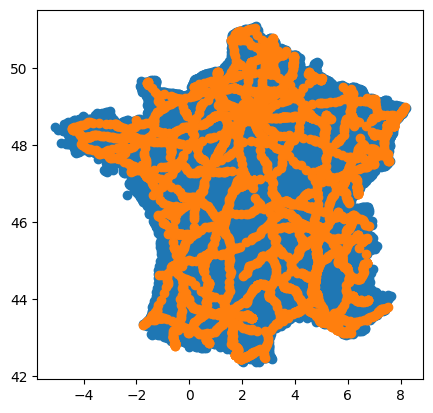

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)

communes_metropole['coords_centre'].plot(ax=ax)
tmja_wrs84['Road_center'].plot(ax=ax)


-----------

In [108]:
DIST_VOL_OISEAU = 70000 # meters

In [109]:
len(communes_metropole)

34461

In [110]:

dist = geopy.distance.geodesic((38.8459879,117.454361),(38.846255,117.459880))
dist.meters

480.04157936467374

In [114]:
tmja_wrs84

,dateRefere,route,longueur,prD,depPrD,concession,absD,cumulD,xD,yD,...,yF,zF,cote,anneeMesur,typeCompta,tmja,pctPL,geometry,list_points,Road_center
0,2018-01-01,69D0301,6055.0,2,69,N,-981.0,0.0,844036.84,6510806.45,...,6509342.34,0.0,I,0,None,0,0.0,"LINESTRING (4.85057 45.68163, 4.85068 45.68180...","[(4.850574731508833, 45.68162878010838), (4.85...",POINT (4.88473 45.68064)
1,2018-01-01,69D0383,13752.0,4,69,N,-494.0,0.0,846831.30,6522372.16,...,6512429.80,0.0,I,0,None,0,0.0,"LINESTRING (4.89002 45.78515, 4.89044 45.78476...","[(4.850574731508833, 45.68162878010838), (4.85...",POINT (4.88103 45.73453)
2,2018-01-01,69D0383BPNL,2408.0,0,69,N,0.0,0.0,844982.46,6522772.27,...,6522372.16,0.0,I,0,None,0,0.0,"LINESTRING (4.86635 45.78915, 4.86652 45.78922...","[(4.850574731508833, 45.68162878010838), (4.85...",POINT (4.87845 45.79095)
3,2018-01-01,75000C01,35040.0,0,75,N,0.0,0.0,655221.44,6858722.80,...,6858722.80,0.0,I,0,None,0,0.0,"LINESTRING (2.28085 48.87830, 2.28107 48.87860...","[(4.850574731508833, 45.68162878010838), (4.85...",POINT (2.33644 48.85780)
4,2018-01-01,75000C02,35040.0,0,75,N,0.0,0.0,655227.28,6858703.75,...,6858703.75,0.0,I,0,None,0,0.0,"LINESTRING (2.28063 48.87837, 2.28082 48.87862...","[(4.850574731508833, 45.68162878010838), (4.85...",POINT (2.33640 48.85782)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5963,2018-01-01,N1547,2687.0,6,13,N,0.0,0.0,895516.86,6250912.48,...,6250945.63,0.0,I,2018,8,0,0.0,"LINESTRING (5.40975 43.33051, 5.40962 43.33043...","[(4.850574731508833, 45.68162878010838), (4.85...",POINT (5.39351 43.33022)
5964,2018-01-01,P0224,8995.0,211,31,N,-638.0,0.0,555988.61,6288880.30,...,6287175.90,0.0,I,0,None,0,0.0,"LINESTRING (1.21422 43.68430, 1.21448 43.68436...","[(4.850574731508833, 45.68162878010838), (4.85...",POINT (1.25496 43.66936)
5965,2018-01-01,P0524,1777.0,31,33,N,-768.0,0.0,440252.10,6361052.92,...,6359374.43,0.0,I,0,None,0,0.0,"LINESTRING (-0.25658 44.30029, -0.25652 44.300...","[(4.850574731508833, 45.68162878010838), (4.85...",POINT (-0.25450 44.29353)
5966,2018-01-01,P0524,3860.0,31,33,N,1009.0,1777.0,458798.85,6325912.32,...,6322872.51,0.0,I,0,None,0,0.0,"LINESTRING (-0.00751 43.99087, -0.00751 43.990...","[(4.850574731508833, 45.68162878010838), (4.85...",POINT (-0.01313 43.97918)


In [144]:
tmja_wrs84.geometry.to_list()[0].coords[1]

(4.8506782641048005, 45.68180185688502)

In [176]:
nearlier_road = []
nearlier_road_dist = []

for k, coord_center in enumerate(communes_metropole['coords_centre'].geometry):

    list_index_nearly = []
    list_coord_nearly = []
    list_dist = []

    for i, road in enumerate(tmja_wrs84['Road_center'].geometry):
        #points_df = gpd.GeoDataFrame({'geometry': [coord_road, coord_center]}, crs='EPSG:4326')
        #points_df = points_df.to_crs('EPSG:5234')
        #points_df2 = points_df.shift()
        dist_oiseau = geopy.distance.geodesic(coord_center.coords, road.coords).meters
        if dist_oiseau<=DIST_VOL_OISEAU:
            list_index_nearly.append(i)
            try:
                list_coord_nearly.append([tupple_coord for tupple_coord in tmja_wrs84.geometry.to_list()[i].coords])
            except:
                print(f'pb of geometry with road {tmja_wrs84.iloc[i,2]}... replace by center of the road')
                list_coord_nearly.append([road.coords])
    
    # ICI, REMPLACER PAR CALCUL API DE DISTANCE TEMPORELLE ROUTIERE
    # ET BOUCLE AVEC REQUETES À L'API POUR EVALUATION DU TEMPS ROUTIER DU POINT COMMUNE À CHAQUE POINT DE ROUTE DE LA LISTE
    #for coord_road in list_coord_nearly:
        # ...
        # best_dist =
        # best_index = 

    # SOLUTION DE REMPLACEMENT (VOL D'OISEAU)
    dist_minimal = DIST_VOL_OISEAU
    best_road = 'nan'

    for i, road_list_points in enumerate(list_coord_nearly):

        min_for_this_road = min([geopy.distance.geodesic(coord_center.coords, tupple).meters for tupple in road_list_points])

        if min_for_this_road < dist_minimal:
            dist_minimal = min_for_this_road

            best_road = list_index_nearly[i]

    nearlier_road_dist.append(dist_minimal)

    nearlier_road.append(tmja_wrs84.iloc[best_road,1])

    if k%100==0:
        print(f'{k} communes completed...')

communes_metropole['nearlier_road']=  nearlier_road
communes_metropole['nearlier_road_dist']=  nearlier_road_dist

0 communes completed...
pb of geometry with road 38064.0... replace by center of the road
pb of geometry with road 38064.0... replace by center of the road
pb of geometry with road 38064.0... replace by center of the road
pb of geometry with road 38064.0... replace by center of the road
pb of geometry with road 38064.0... replace by center of the road
pb of geometry with road 38064.0... replace by center of the road
pb of geometry with road 38064.0... replace by center of the road
pb of geometry with road 38064.0... replace by center of the road
pb of geometry with road 38064.0... replace by center of the road
pb of geometry with road 38064.0... replace by center of the road
pb of geometry with road 38064.0... replace by center of the road
pb of geometry with road 38064.0... replace by center of the road
pb of geometry with road 38064.0... replace by center of the road
pb of geometry with road 38064.0... replace by center of the road
pb of geometry with road 38064.0... replace by cente

KeyboardInterrupt: 

In [177]:
nearlier_road

['N0116',
 'N0116',
 'A0009',
 'N0116',
 'N0116',
 'N0116',
 'A0009',
 'N0116',
 'N0116',
 'N0020',
 'A0009',
 'A0009',
 'A0009',
 'N0116',
 'A0009',
 'A0009',
 'N0116',
 'N0116',
 'N0116',
 'N0116',
 'N0116',
 'N0116',
 'N0116',
 'N0116',
 'N0116',
 'N0116',
 'N0116',
 'N0116',
 'N0116',
 'A0009',
 'N0116',
 'N0116',
 'N0020',
 'N0116',
 'N0116',
 'N0020',
 'N0116',
 'N0116',
 'A0009',
 'A0009',
 'A0009',
 'A0009',
 'A0009',
 'A0075',
 'A0075',
 'A0075',
 'N0088',
 'A0075',
 'N0088',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0009',
 'A0009',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0009',
 'A0075',
 'A0075',
 'N0102',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'A0075',
 'N0102',
 'N0102',
 'N0102',
 'N0102',
 'N0102',
 'A0075',
 'N0102',
 'N0102',
 'N0102',
 'N0102',
 'A0075',
 'N0102',
 'N0102',
 'N0102',
 'N0102',
 'N0102',


In [178]:
nearlier_road_dist

[18758.257768946005,
 6288.0758751017565,
 3568.5462682043303,
 256.1863938173784,
 2811.286840472148,
 4036.669628563523,
 19.411995195646313,
 318.486253009331,
 4134.780505237799,
 3060.998938044942,
 16268.514818549555,
 4832.144326513472,
 659.621337461792,
 29188.604363815568,
 24686.65751764036,
 22052.6722711289,
 18217.938960795356,
 22453.05325002267,
 21707.829514711724,
 20119.59633872426,
 9898.427737476106,
 11118.536781706192,
 5388.023283419751,
 3816.3942609063533,
 2972.423453868242,
 910.6882149484353,
 494.0812694227119,
 5784.034480538759,
 4960.831740136477,
 12803.049082605601,
 5614.967679736661,
 7439.333670444153,
 241.175430715598,
 6004.405645268577,
 4827.091898287741,
 306.6003632080051,
 1696.712018731555,
 42.646310067051125,
 7910.238583616043,
 26739.990616550404,
 25873.64895369029,
 31292.551883829623,
 4638.086568185341,
 23368.981653912997,
 7904.462142775925,
 4479.323753831134,
 756.5202443973442,
 3604.3822671269677,
 38.7526861137902,
 277.4357

In [179]:
len(nearlier_road)

6786

In [180]:
len(nearlier_road_dist)

6786

In [182]:
first_test_df = communes_metropole.iloc[0:6786,:]

In [183]:
first_test_df['nearlier_road'] = nearlier_road
first_test_df['nearlier_road_dist'] = nearlier_road_dist

/home/jesshuan/miniconda3/envs/ECartoMobile/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/jesshuan/miniconda3/envs/ECartoMobile/lib/python3.11/site-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

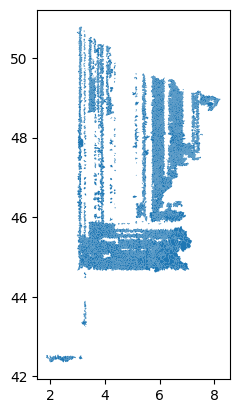

In [188]:
first_test_df.plot()

In [186]:
filename = 'test_route_proches_communes_part_1'
first_test_df.to_feather(os.path.join(data_path,file_name + '.feather'))

In [193]:
tmja_wrs84

,dateRefere,route,longueur,prD,depPrD,concession,absD,cumulD,xD,yD,...,yF,zF,cote,anneeMesur,typeCompta,tmja,pctPL,geometry,list_points,Road_center
0,2018-01-01,69D0301,6055.0,2,69,N,-981.0,0.0,844036.84,6510806.45,...,6509342.34,0.0,I,0,None,0,0.0,"LINESTRING (4.85057 45.68163, 4.85068 45.68180...","[(4.850574731508833, 45.68162878010838), (4.85...",POINT (4.88473 45.68064)
1,2018-01-01,69D0383,13752.0,4,69,N,-494.0,0.0,846831.30,6522372.16,...,6512429.80,0.0,I,0,None,0,0.0,"LINESTRING (4.89002 45.78515, 4.89044 45.78476...","[(4.850574731508833, 45.68162878010838), (4.85...",POINT (4.88103 45.73453)
2,2018-01-01,69D0383BPNL,2408.0,0,69,N,0.0,0.0,844982.46,6522772.27,...,6522372.16,0.0,I,0,None,0,0.0,"LINESTRING (4.86635 45.78915, 4.86652 45.78922...","[(4.850574731508833, 45.68162878010838), (4.85...",POINT (4.87845 45.79095)
3,2018-01-01,75000C01,35040.0,0,75,N,0.0,0.0,655221.44,6858722.80,...,6858722.80,0.0,I,0,None,0,0.0,"LINESTRING (2.28085 48.87830, 2.28107 48.87860...","[(4.850574731508833, 45.68162878010838), (4.85...",POINT (2.33644 48.85780)
4,2018-01-01,75000C02,35040.0,0,75,N,0.0,0.0,655227.28,6858703.75,...,6858703.75,0.0,I,0,None,0,0.0,"LINESTRING (2.28063 48.87837, 2.28082 48.87862...","[(4.850574731508833, 45.68162878010838), (4.85...",POINT (2.33640 48.85782)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5963,2018-01-01,N1547,2687.0,6,13,N,0.0,0.0,895516.86,6250912.48,...,6250945.63,0.0,I,2018,8,0,0.0,"LINESTRING (5.40975 43.33051, 5.40962 43.33043...","[(4.850574731508833, 45.68162878010838), (4.85...",POINT (5.39351 43.33022)
5964,2018-01-01,P0224,8995.0,211,31,N,-638.0,0.0,555988.61,6288880.30,...,6287175.90,0.0,I,0,None,0,0.0,"LINESTRING (1.21422 43.68430, 1.21448 43.68436...","[(4.850574731508833, 45.68162878010838), (4.85...",POINT (1.25496 43.66936)
5965,2018-01-01,P0524,1777.0,31,33,N,-768.0,0.0,440252.10,6361052.92,...,6359374.43,0.0,I,0,None,0,0.0,"LINESTRING (-0.25658 44.30029, -0.25652 44.300...","[(4.850574731508833, 45.68162878010838), (4.85...",POINT (-0.25450 44.29353)
5966,2018-01-01,P0524,3860.0,31,33,N,1009.0,1777.0,458798.85,6325912.32,...,6322872.51,0.0,I,0,None,0,0.0,"LINESTRING (-0.00751 43.99087, -0.00751 43.990...","[(4.850574731508833, 45.68162878010838), (4.85...",POINT (-0.01313 43.97918)


<Axes: >

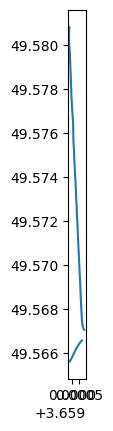

In [199]:
tmja_wrs84.loc[tmja_wrs84['longueur']==1677,:].geometry.plot()